In [11]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import lib, gto, scf
import pyqmc.recipes
import h5py
import matplotlib.pyplot as plt

This function computes the mean-field solution and saves the results to the file specified. We recommend using the ccecp pseudopotentials for high accuracy and efficiency.

In [7]:
def mean_field(chkfile):
    mol = gto.M(atom = "O 0 0 0; H 0 -2.757 2.587; H 0 2.757 2.587", basis='ccecpccpvdz', ecp='ccecp', unit='bohr')

    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()
mean_field("h2o.hdf5")

converged SCF energy = -16.4791748386414


(<pyscf.gto.mole.Mole at 0x121ef5e50>, <pyscf.scf.hf.RHF at 0x11cb15710>)

Now we wish to construct a Slater-Jastrow wave function and optimize its energy. This is done automatically using the OPTIMIZE function in pyqmc.recipes. It's often helpful to do the first optimization with only a few configurations, to get close to the minimum cheaply.

In [8]:

pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj.hdf5",nconfig=200)

default ion_cusp: []
starting warmup
----------vmc done
----------vmc done
descent en -16.509127458267674 0.01698405119252304  estimated sigma  2.401907554050502
descent |grad| 0.5761731017029442
----------vmc done
descent en -16.658555820961492 0.010172418599397845  estimated sigma  1.4385972345404756
descent |grad| 0.312495867881528
----------vmc done
descent en -16.690484097967488 0.006673124342664708  estimated sigma  0.9437222948798476
descent |grad| 0.17275683521482335
----------vmc done
descent en -16.69400922617807 0.008452054000542181  estimated sigma  1.1953009397476528
descent |grad| 0.17313621963196812
----------vmc done
descent en -16.73229229781426 0.010044362730603657  estimated sigma  1.4204873999014547
descent |grad| 0.11116212468659813
----------vmc done
descent en -16.6998351831478 0.009208640729552879  estimated sigma  1.3022984610754955
descent |grad| 0.18032767303839403
----------vmc done
descent en -16.72149622385774 0.0069309259782294845  estimated sigma  0.9801

Once the calculation is done, you should graph the energy versus iteration.

<ErrorbarContainer object of 3 artists>

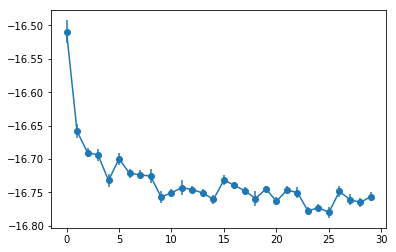

In [12]:
with h5py.File("h2o_sj.hdf5") as f:
    en=f['energy'][...]
    it=f['iteration'][...]
    err=f['energy_error'][...]
plt.errorbar(it,en,err, marker='o')


You should note that towards the end of the calculation, the energy fluctuates quite a bit. We can improve that by running with more configurations. We will do this using a slightly more advanced invocation of OPTIMIZE:

* Running in parallel. For this we will use the futures library, built into python, which can easily parallelize on one computer. You can also use the dask distributed to run over multiple computers.

* Since we want to start from the previous optimization, we use the `start_from` command in OPTIMIZE.

* Setting a keyword for the line minimization algorithm `linemin_kws` so it only runs for 10 iterations, just to keep the computation low for this example.

In [15]:
import concurrent.futures
npartitions = 2 # number of cores to use
with concurrent.futures.ProcessPoolExecutor(max_workers=npartitions) as client:
    pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj_moreconfigs.hdf5", start_from="h2o_sj.hdf5", nconfig=800, client=client, npartitions=npartitions, linemin_kws=dict(max_iterations=10))


default ion_cusp: []
starting warmup
-Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x10c5ae9e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tempfile.py", line 448, in __del__
    self.close()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/tempfile.py", line 444, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/zl/ryjxc2qd7lj7jbvv01y0q6rr0000gn/T/tmpw66kfz98'
---------vmc done
----------vmc done
descent en -16.75942980239655 0.003929255087019325  estimated sigma  1.1113611668172414
descent |grad| 0.040610708509815116
----------vmc done
descent en -16.760079939936638 0.0025318516521000652  estimated sigma  0.7161157888633279
descent |grad| 0.031384100760252956
----------vmc done
descent en -16.764711994953494 0.002926494495734027  estimated sigma  0.8277376412154547
descent |grad| 0.02959

<ErrorbarContainer object of 3 artists>

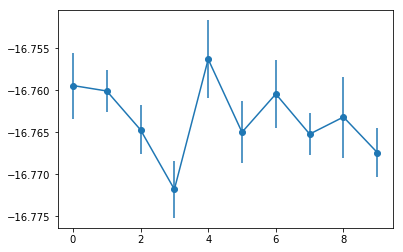

In [17]:
with h5py.File("h2o_sj_moreconfigs.hdf5") as f:
    en=f['energy'][...]
    it=f['iteration'][...]
    err=f['energy_error'][...]
plt.errorbar(it,en,err, marker='o')


As you can see here, the fluctuations in the total energy estimation are much reduced but we don't get a lot better in terms of total energy. This is because the algorithm is able to very efficiently find the minimum even when the energy is not well-resolved!

Now we have an optimized Slater-Jastrow wave function for our system. We may want to evaluate properties of this wave function. Here we will compute the one-body reduced density matrix. 

In [33]:
with concurrent.futures.ProcessPoolExecutor(max_workers=npartitions) as client:
    pyqmc.recipes.VMC("h2o.hdf5","h2o_sj_vmc.hdf5", 
                      start_from="h2o_sj_moreconfigs.hdf5", 
                      client=client, 
                      npartitions=npartitions, 
                      accumulators=dict(rdm1=True),
                      vmc_kws=dict(nblocks=100)
                      )


default ion_cusp: []
Restarting calculation from step 40
----------------------------------------------------------------------------------------------------vmc done


For the Hartree-Fock wave function, the occupations of the 1-RDM would be equal to 2 or 0. The Jastrow factor introduces correlation, which changes the electron density, hopping, etc.

['block', 'configs', 'energyecp', 'energyee', 'energyei', 'energyke', 'energytotal', 'nconfig', 'rdm1acceptance', 'rdm1norm', 'rdm1value']


(-0.05, 0.05)

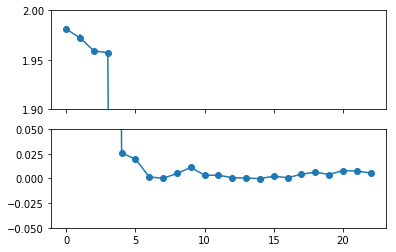

In [49]:
import pyqmc.obdm
def avg(vec):
    nblock = vec.shape[0]
    avg = np.mean(vec,axis=0)
    std = np.std(vec,axis=0)
    return avg, std/np.sqrt(nblock)

with h5py.File("h2o_sj_vmc.hdf5") as f:
    print(list(f.keys()))
    warmup=2
    en, en_err = avg(f['energytotal'][warmup:,...])
    rdm1, rdm1_err=avg(f['rdm1value'][warmup:,...])
    rdm1norm, rdm1norm_err = avg(f['rdm1norm'][warmup:,...])
    rdm1=pyqmc.obdm.normalize_obdm(rdm1,rdm1norm)
    rdm1_err=pyqmc.obdm.normalize_obdm(rdm1_err,rdm1norm)

norb=rdm1.shape[0]
fig, axes=plt.subplots(2,1, sharex=True)
axes[0].errorbar(range(norb),rdm1.diagonal(), rdm1_err.diagonal(), marker='o')
axes[1].errorbar(range(norb),rdm1.diagonal(), rdm1_err.diagonal(), marker='o')
axes[0].set_ylim((1.9,2.0))
axes[1].set_ylim((-0.05,0.05))

We can compute the density from the 1-RDM, using pyscf objects. By default, the 1-RDM is computed in the molecular orbital basis, and the cubegen utility wants it in the AO basis. 

In [52]:
mol, mf = pyqmc.recover_pyscf("h2o.hdf5")
import pyscf.tools
ao_rdm1 = np.einsum('pi,ij,qj->pq', mf.mo_coeff, rdm1, mf.mo_coeff.conj())
dens=pyscf.tools.cubegen.density(mol, "h2o_sj_density.cube",ao_rdm1)

dict_keys(['atoms', 'data', 'origin'])
(80, 80, 80)
0.910362 1.37525e-06


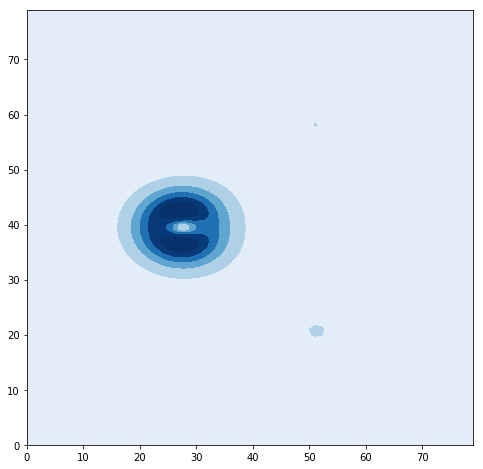

In [75]:
import ase.io
data = ase.io.cube.read_cube(open("h2o_sj_density.cube"))
print(data.keys())
print(data['data'].shape)
yzplane = data['data'][40,:,:]
fig = plt.figure(figsize=(8,8))
print(np.max(yzplane), np.min(yzplane))
plt.contourf(yzplane, cmap='Blues', vmin=0.0, vmax=0.7)
